# Strut force and earth pressures

In this script we analyse strut force and earth pressures data that were collected on the instrumented construction site in Alpnachstad. 

**Input:**

*   a csv-file '`rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv`'. It contains the data automatically collected with the Catman software. This file is constructed partially by hand, partially with the help of two python scripts (they are not available on Google Colab, only on the server P:).
*   a csv-file '`rawdata_Klima_aussen.csv`'. It contains the climate data (temperature, humidity, etc.) ouside the box where all the electronics where stored. This data is used to investigate the temperature effects.

**Output:**

*   none. This Jupyter-Notebook is dedicated to exploratory data analysis. 

In [ ]:
#hide
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

# install dependency (nbdev version 1 and patch tornado problem)
!pip3 install --upgrade notebook
!pip3 install -e . -q
!pip3 install nbdev==1.2.11 -q

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done


# Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import io
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

# 1.0. Import the data

# 1.1. Read the Catman data

In [ ]:
CATMAN_FILE_NAME = './data/rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv'
df_catman = pd.read_csv(CATMAN_FILE_NAME, delimiter=';')
#print(df_catman)
#print(df_catman.columns)

# important note: one column has mistakenly been labelled 'EV31'. In reality it measured the strain gauge EH31

cols = ['EH31', 'EV31']
df_catman = df_catman.assign(E = df_catman[cols].sum(1)).drop(cols, 1)
df_catman.rename(columns = {'E':'EH31'}, inplace = True)
print(df_catman)
print(df_catman.columns)

# covert the column 'Zeit' into python datetime objects and sort in chronological order

for index, row in df_catman.iterrows():
    df_catman.at[index, 'Zeit'] = datetime.strptime(df_catman.at[index, 'Zeit'], '%d.%m.%Y %H:%M')

df_catman = df_catman.sort_values('Zeit', ascending=True)

      Unnamed: 0         EDSA          EDSB         EDSC  EDSD          EDSE  \
0              0  -7687.31982  2.179666e+06 -35919.26172   NaN  1.226793e+04   
1              1  -7719.16553  2.169327e+06 -35989.06641   NaN  1.233930e+04   
2              2  -7820.88623  2.159840e+06 -36016.18750   NaN  1.243958e+04   
3              3    183.08820  1.934437e+06 -20862.70313   NaN  1.955401e+04   
4              4  -8862.40723  1.705553e+06 -26351.51563   NaN  1.095719e+04   
...          ...          ...           ...          ...   ...           ...   
1885        1885 -63382.89844 -2.563729e+04          NaN   NaN -4.819262e+06   
1886        1886 -58923.52344 -2.356395e+04          NaN   NaN -4.824424e+06   
1887        1887 -44199.95703 -1.748341e+04          NaN   NaN -4.816859e+06   
1888        1888 -29251.58594 -1.084607e+04          NaN   NaN -4.816321e+06   
1889        1889 -24097.75977 -8.154800e+03          NaN   NaN -4.816772e+06   

           EDSF         EDSG     Tempa 

<ipython-input-3-aeb11365cd94>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_catman = df_catman.assign(E = df_catman[cols].sum(1)).drop(cols, 1)


# 1.2. Read the climate data

In [ ]:
KLIMA_AUSSEN_FILE_NAME = './data/rawdata_Klima_aussen.csv'
df_klima = pd.read_csv(KLIMA_AUSSEN_FILE_NAME, delimiter=';')

# covert the column 'Aufnahmezeit' into python datetime objects and sort them in chronological order: 
for index, row in df_klima.iterrows():
    df_klima.at[index, 'Aufnahmezeit'] = datetime.strptime(df_klima.at[index, 'Aufnahmezeit'], '%d.%m.%Y  %H:%M')

df_klima = df_klima.sort_values('Aufnahmezeit', ascending=True)
df_klima = df_klima.drop(columns='Unnamed: 0', axis=1)

print(df_klima)
print(df_klima.columns)

             Aufnahmezeit  Temperatur  Relative Luftfeuchtigkeit  Taupunkt
0     2021-07-14 11:44:00        26.3                       41.5     12.19
1     2021-07-14 12:14:00        24.8                       49.9     13.64
2     2021-07-14 12:44:00        24.0                       50.9     13.21
3     2021-07-14 13:14:00        21.3                       56.3     12.25
4     2021-07-14 13:44:00        21.0                       61.2     13.25
...                   ...         ...                        ...       ...
6410  2022-04-12 03:01:00         4.3                       80.6      1.27
6411  2022-04-12 04:01:00         3.9                       82.6      1.22
6412  2022-04-12 05:01:00         3.6                       83.8      1.12
6413  2022-04-12 06:01:00         4.8                       82.3      2.05
6414  2022-04-12 07:01:00         7.8                       75.3      3.71

[6415 rows x 4 columns]
Index(['Aufnahmezeit', 'Temperatur', 'Relative Luftfeuchtigkeit', 'Taupunkt

# 2.0. Strut force

The sheet pile wall was supported by struts (double HEB 300 profiles) and stiffened with horizontal bracing (HEB 600 profile). The struts spanned from the underground garage walls to the excavation supporting system. 
Unfortunately, the struts were installed on the 07.02.2022 or on the 08.02.2022, that is, after the excavation was concluded. For this reason, we expect the strut forces to be relatively low. 

The strut force was measured by two load cells (in German "Kraftmessdosen", KMD) and a temperature sensor Temp_c was employed to compensate the temperature drift in the load cells. The unit is [kN]. Positive values indicate pressure, and negative ones indicate tension. 

The load cells were simply placed between the strut and the horizontal bracing (in German "Longarine"), and they were not bolted together with either one. This means the load cells cannot measure tension, bur rather pressure only. 

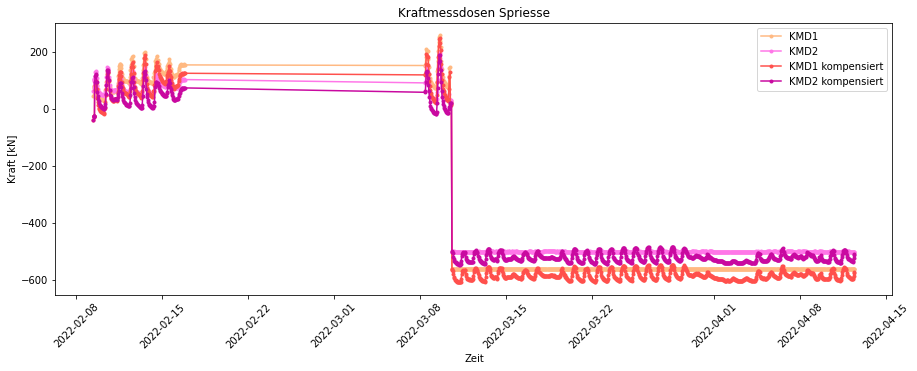

In [ ]:
# Kraftmessdosen

plt.figure(figsize=(15,5))
plt.title('Kraftmessdosen Spriesse')
plt.plot(df_catman.Zeit, df_catman.KMD1, color='#ffb982', marker='.', label = 'KMD1')
plt.plot(df_catman.Zeit, df_catman.KMD2, color='#ff76e8', marker='.', label = 'KMD2')
plt.plot(df_catman.Zeit, df_catman.KMD1kompensiert, color='#ff504c', marker='.', label = 'KMD1 kompensiert')
plt.plot(df_catman.Zeit, df_catman.KMD2kompensiert, color='#c909a0', marker='.', label = 'KMD2 kompensiert')
plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

In [ ]:
# There a significant drop in the measured strut force on the 10h of March 2022. Why?

print(df_catman.KMD1[1101:1103])
print(df_catman.Zeit[1101:1103])

1101     24.66656
1102   -563.16864
Name: KMD1, dtype: float64
1101    2022-03-10 13:44:00
1102    2022-03-10 14:44:00
Name: Zeit, dtype: object


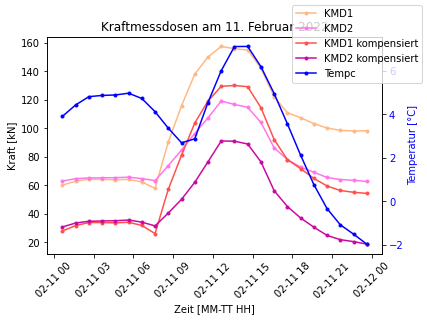

In [ ]:
# Does the strut force correlate with the outside temperature? 
# Time period before the force drops

fig, ax1 = plt.subplots()
ax1.set_title('Kraftmessdosen am 11. Februar 2022')

ax1.plot(df_catman.Zeit[909:933], df_catman.KMD1[909:933], color='#ffb982', marker='.', label = 'KMD1')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD2[909:933], color='#ff76e8', marker='.', label = 'KMD2')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD1kompensiert[909:933], color='#ff504c', marker='.', label = 'KMD1 kompensiert')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD2kompensiert[909:933], color='#c909a0', marker='.', label = 'KMD2 kompensiert')

ax1.set_xlabel('Zeit [MM-TT HH]') 
ax1.set_ylabel('Kraft [kN]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_catman.Zeit[909:933], df_catman['Tempc'][909:933],'b.-', label='Tempc')
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
fig.legend()

fig.show()

# Obviously, the strut force does show a correlation with temperature even after compensation.
# In fact, the strut expands and contracts because of the temperature variations and sun exposure 
# during the day. This effect cannot be removed by mathematical means. 

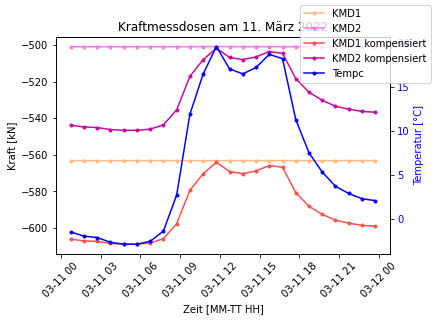

In [ ]:
# Does the strut force correlate with the outside temperature? 
# Time period after the force drops

fig, ax1 = plt.subplots()
ax1.set_title('Kraftmessdosen am 11. März 2022')

ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD1[1112:1136], color='#ffb982', marker='.', label = 'KMD1')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD2[1112:1136], color='#ff76e8', marker='.', label = 'KMD2')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD1kompensiert[1112:1136], color='#ff504c', marker='.', label = 'KMD1 kompensiert')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD2kompensiert[1112:1136], color='#c909a0', marker='.', label = 'KMD2 kompensiert')

ax1.set_xlabel('Zeit [MM-TT HH]') 
ax1.set_ylabel('Kraft [kN]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_catman.Zeit[1112:1136], df_catman['Tempc'][1112:1136],'b.-', label='Tempc') # Tempc oder 'Temperatur aussen' ??
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
fig.legend()

fig.show()

# The raw data show a constant, negative value over time. This means either the load cell 
# has stopped working, or there is no more force acting on the strut. Remember, the load 
# cell cannot record tension.

In [ ]:
# the analysis of static behaviour focuses on the period starting from the 4th of December onwards (index 533)
strut_cols = ['Zeit', 'KMD1', 'KMD2', 'KMD1kompensiert', 'KMD2kompensiert']
df_strut = df_catman[867:][strut_cols]


# downsampling to a weekly frequency
df_strut_downsample = df_strut.resample('D', on='Zeit').mean()


# Calculate the timestamp based on index value
for index, row in df_strut_downsample.iterrows():
  df_strut_downsample.at[index, 'Zeit_timestamp'] = index.timestamp()


df_strut_downsample

,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,Zeit_timestamp
Zeit,,,,,
2022-02-09,64.272527,87.060536,17.648408,34.248911,1.644365e+09
2022-02-10,68.349015,77.011854,37.792234,46.455072,1.644451e+09
2022-02-11,101.870650,79.086090,68.807916,46.023355,1.644538e+09
2022-02-12,118.340781,77.621131,79.715651,38.996000,1.644624e+09
2022-02-13,120.598537,78.486779,85.857876,43.746117,1.644710e+09
...,...,...,...,...,...
2022-04-08,-563.123865,-500.702510,-577.731317,-515.309963,1.649376e+09
2022-04-09,-563.125256,-500.691201,-589.505355,-527.071299,1.649462e+09
2022-04-10,-563.127223,-500.716377,-584.637718,-522.226874,1.649549e+09


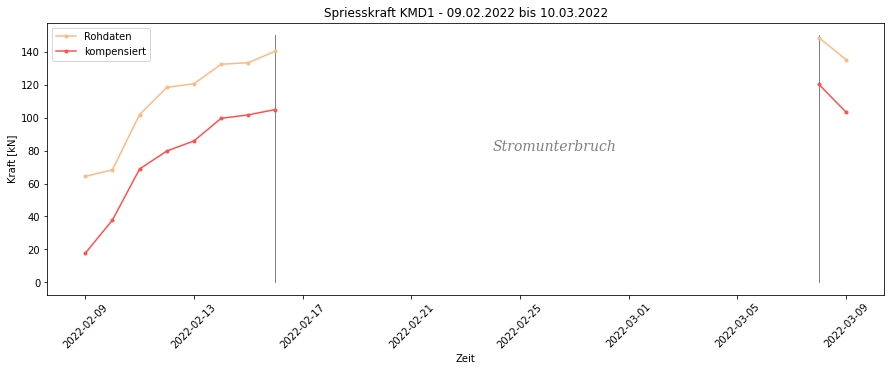

In [ ]:
# create the data needed to plot the beginning and the end of the electricity supply interruption on the graph

begin_elsupply = datetime(2022, 2, 16, 0, 0)
end_elsupply = datetime(2022, 3, 8, 0, 0)

beginx = [begin_elsupply, begin_elsupply]
beginy = [0, 150]
endx = [end_elsupply, end_elsupply]
endy = [0, 150]


plt.figure(figsize=(15,5))
plt.title('Spriesskraft KMD1 - 09.02.2022 bis 10.03.2022')

font_elsupply = {'family': 'serif', 'color': 'grey' , 'size': 14, 'style': 'italic'}
plt.text(datetime(2022, 2, 24, 0, 0), 80, 'Stromunterbruch', fontdict=font_elsupply)
plt.plot(beginx, beginy, color='grey', linewidth=1)
plt.plot(endx, endy, color='grey', linewidth=1)

plt.plot(df_strut_downsample.KMD1[0:29], color='#ffb982', marker='.', label='Rohdaten')
plt.plot(df_strut_downsample.KMD1kompensiert[0:29], color='#ff504c', marker='.', label='kompensiert')


plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

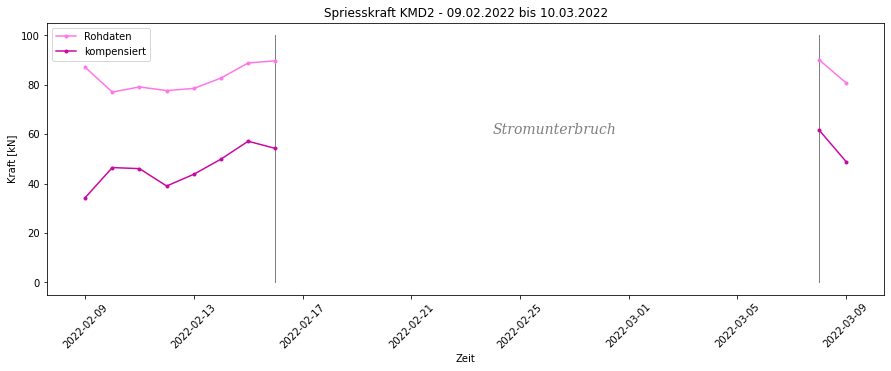

In [ ]:
# create the data needed to plot the beginning and the end of the electricity supply interruption on the graph

begin_elsupply = datetime(2022, 2, 16, 0, 0)
end_elsupply = datetime(2022, 3, 8, 0, 0)

beginx = [begin_elsupply, begin_elsupply]
beginy = [0, 100]
endx = [end_elsupply, end_elsupply]
endy = [0, 100]


plt.figure(figsize=(15,5))
plt.title('Spriesskraft KMD2 - 09.02.2022 bis 10.03.2022')

font_elsupply = {'family': 'serif', 'color': 'grey' , 'size': 14, 'style': 'italic'}
plt.text(datetime(2022, 2, 24, 0, 0), 60, 'Stromunterbruch', fontdict=font_elsupply)
plt.plot(beginx, beginy, color='grey', linewidth=1)
plt.plot(endx, endy, color='grey', linewidth=1)

plt.plot(df_strut_downsample.KMD2[0:29], color='#ff76e8', marker='.', label='Rohdaten')
plt.plot(df_strut_downsample.KMD2kompensiert[0:29], color='#c909a0', marker='.', label='kompensiert')


plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

**Conclusions**

On Thursday, March the 10th 2022, the strut force drops suddenly by ca. 500 - 600 kN. The exact reason is unknown. However, it may indicate one of these two things: either the load cell has stopped working, or there is no more force acting on the strut. 

From the moment of installation up to the electricity supply interruption, KMD1 records an increase in strut force to about 100 kN. KMD2 shows a less clear tend, the final force settling at around 55 kN. 

# 3.0. Earth pressure cells
Let's explore the data stemming from the earth pressure cells (in German "Erddrucksensoren", EDS). We want to check if the data is reliable and can thus be used to investigate the static behaviour of the sheet piles. The unit is Pa = N/m2. 

On the 25th of Augus 2021, an additional earth pressure cell was installed at a depth of 3.2 m below top edge of sheet piles. The cell EDS_B was unplugged and EDS_B2 was plugged in instead. However, the channel name remained unchanged. For this reason, we have to separate the data concerning EDS_B and EDS_B2 manually. 

In [ ]:
date_of_switch_sensor_B = datetime(2021, 8, 25, 0, 0)

df_catman['EDSB2'] = df_catman['EDSB']
df_catman.loc[df_catman.Zeit < date_of_switch_sensor_B, "EDSB2"] = np.nan
df_catman.loc[df_catman.Zeit >= date_of_switch_sensor_B, "EDSB"] = np.nan
df_catman[['EDSB', 'EDSB2']]

,EDSB,EDSB2
0,2179665.500,NaN
1,2169327.000,NaN
2,2159839.500,NaN
3,1934437.250,NaN
4,1705552.875,NaN
...,...,...
1885,NaN,-25637.29102
1886,NaN,-23563.95313
1887,NaN,-17483.40820
1888,NaN,-10846.06934


In [ ]:
EDS = ['EDSA', 'EDSB', 'EDSB2','EDSC', 'EDSD', 'EDSE', 'EDSF', 'EDSG']
df_catman[EDS].describe()

,EDSA,EDSB,EDSB2,EDSC,EDSD,EDSE,EDSF,EDSG
count,1890.000000,9.400000e+01,1671.000000,8.180000e+02,0.0,1.890000e+03,1.890000e+03,7.300000e+02
mean,-45562.301405,2.894189e+06,-21378.642852,-1.954239e+06,NaN,-4.135715e+06,-6.296255e+06,-1.906753e+06
std,23042.307474,1.813289e+06,8877.141022,2.616663e+06,NaN,2.007521e+06,4.262913e+04,1.998721e+06
min,-89692.750000,1.529592e+05,-41762.097660,-5.373582e+06,NaN,-5.571818e+06,-6.393995e+06,-5.529060e+06
25%,-62708.442380,1.123557e+06,-27514.009765,-5.181401e+06,NaN,-5.360852e+06,-6.318406e+06,-2.971823e+06
50%,-50383.134765,3.388863e+06,-22824.398440,-1.180169e+06,NaN,-4.928931e+06,-6.305605e+06,-1.402721e+06
75%,-33075.893552,4.577915e+06,-16804.752930,-5.950797e+05,NaN,-3.273082e+06,-6.281504e+06,-7.545307e+05
max,25871.871090,5.329240e+06,3889.726320,2.623248e+06,NaN,5.314492e+06,-6.041358e+06,5.793018e+06


One sensor didn't work from the very start (D). The mean of many EDS is negative, meaning the sensor is registering a suction rather that a pressure. This contradicts our expectations. 
Furthermore, the mean of many sensors (B, C, E, F, and G) is in the order of magnitude of several MPa. This is absolutely unrealistic. According to our expectations, the earth pressure cells should indicate values between 0 and a maximum of 150 kPa, depending from the depth: 

$$ \sigma_h = K_0 \cdot \sigma_v $$
wobei
$$ K_0 = 1-sin(\varphi) \approx 0.5$$
$$ \sigma_v = \gamma \cdot z + q $$

Lastly, a high ratio ${std}/{mean}$ in the above table indicates the values are highly unstable. 

## EDS_A

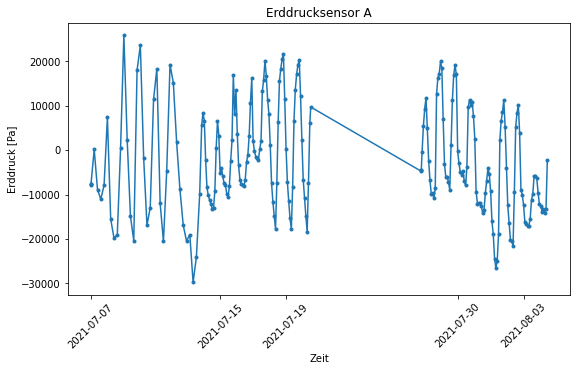

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor A')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSA[0:219], '.-')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

**Correlation with temperature**

Is the EDS data influenced by temperature? Let's investigate if there is any correlation. 

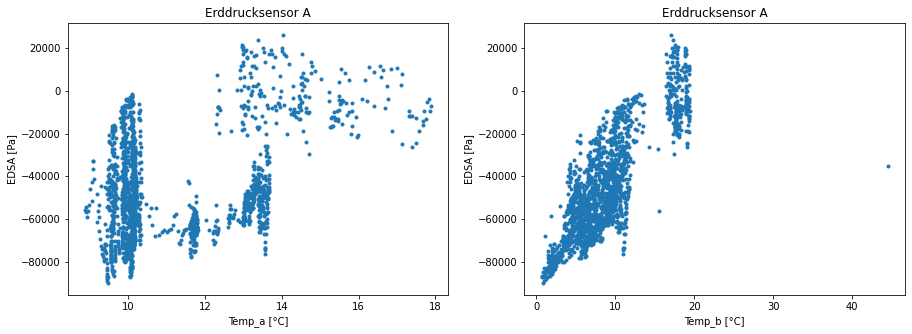

In [ ]:
# Temperature sensors on the sheet piles, Temp_a und Temp_b 

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Erddrucksensor A')
plt.plot(df_catman.Tempa, df_catman.EDSA, '.')
plt.xlabel('Temp_a [°C]')
plt.ylabel('EDSA [Pa]')

plt.subplot(1,2,2)
plt.title('Erddrucksensor A')
plt.plot(df_catman.Tempb, df_catman.EDSA, '.')
plt.xlabel('Temp_b [°C]')
plt.ylabel('EDSA [Pa]')

plt.show()

# For Temp_a, a correlation cannot be recognised. 
# Temp_b shows some correlation. 

**Outside temperature**

The two following code blocks have been copied from, and are therefore identical to, '`05_catman.ipynb`'. 

In [ ]:
# compute temperature values for the same timestamps in df_catman, based on the data in df_klima


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Zeit_timestamp'] = df_catman.at[index, 'Zeit'].timestamp()

for index, row in df_klima.iterrows():
  df_klima.at[index, 'Aufnahmezeit_timestamp'] = df_klima.at[index, 'Aufnahmezeit'].timestamp()


def interpolate(my_timestamp, df, xcol, ycol):
  return np.interp([my_timestamp], df[xcol], df[ycol])


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Temperatur aussen'] = interpolate(df_catman.at[index, 'Zeit_timestamp'], df_klima, 'Aufnahmezeit_timestamp', 'Temperatur')

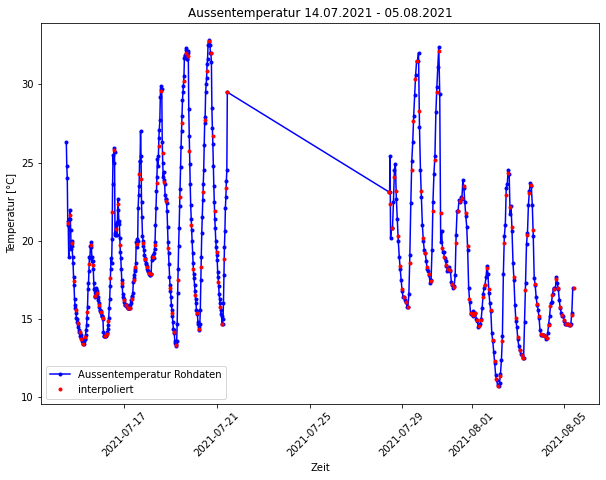

In [ ]:
# temperature effects 14.07.2021 - 05.08.2021

# df_klima: indexes 0 - 526 (included)
# df_catman: indexes 36 - 218 (included)

plt.figure(figsize=(10,7))
plt.title('Aussentemperatur 14.07.2021 - 05.08.2021')

plt.plot(df_klima.Aufnahmezeit[0:527], df_klima.Temperatur[0:527], 'b.-', label = 'Aussentemperatur Rohdaten')
plt.plot(df_catman.Zeit[36:219], df_catman['Temperatur aussen'][36:219], 'r.', label = 'interpoliert')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

intercept: -68930.88358388018
slope: [3077.36121903]
R-squared: 0.924614921137541


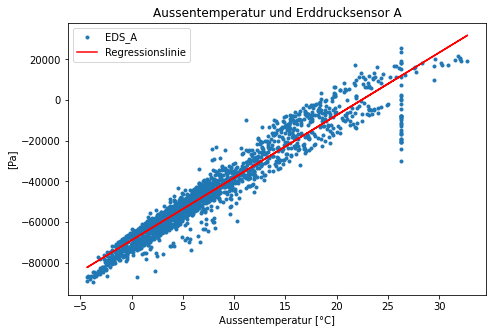

In [ ]:
# Temperature sensor for outside temperature

my_x = pd.DataFrame(df_catman['Temperatur aussen'])
my_y = df_catman.EDSA
regression_model = linear_model.LinearRegression()
regression_model.fit(X = my_x, y = my_y)

print('intercept: ' + str(regression_model.intercept_))
print('slope: ' + str(regression_model.coef_))
print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))

train_prediction = regression_model.predict(X = my_x)

# plot the results
plt.figure(figsize=(7.5,5))

plt.title('Aussentemperatur und Erddrucksensor A')

plt.plot(my_x, my_y, marker='.', linestyle='', label='EDS_A')
plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('[Pa]')
plt.legend()
plt.show()

# Yes, strong correlation. 
# The reader can check on his/her own that the points are not clustered 
# as a result of electricity supply interruptions. The phenomenon that 
# was observed with the strain gauges is therefore not present here with 
# the earth pressure cells.

## EDS_B

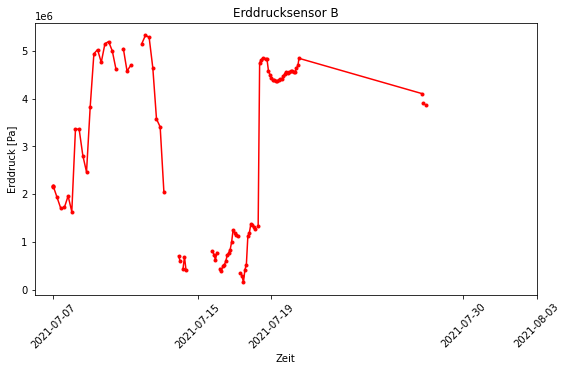

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor B')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSB[0:219], '.-', color='red')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## EDS_B2

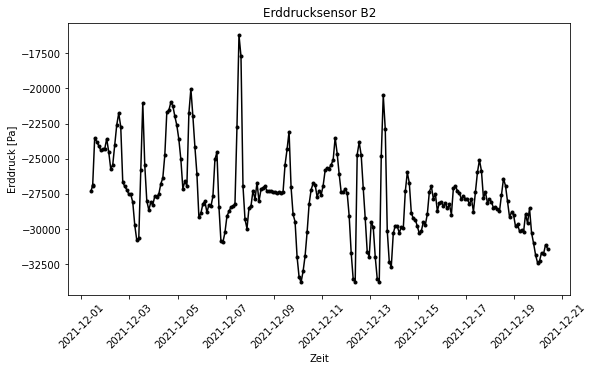

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor B2')

# time period from 01.12. - 20.12.2021
plt.plot(df_catman.Zeit[500:730], df_catman.EDSB2[500:730], '.-', color='black', label='01.12. - 20.12.2021')
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.tick_params(axis='x', rotation=45)
plt.show()

intercept: -30476.093108961213
slope: [1537.24514761]
R-squared: 0.9274417457141592


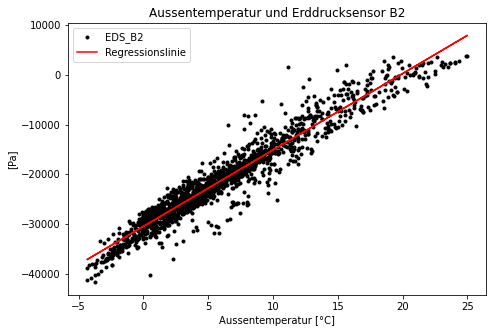

In [ ]:
# investigate the correlation with outside temperature

my_x = pd.DataFrame(df_catman['Temperatur aussen'][219:])
my_y = df_catman.EDSB2[219:]
regression_model = linear_model.LinearRegression()
regression_model.fit(X = my_x, y = my_y)

print('intercept: ' + str(regression_model.intercept_))
print('slope: ' + str(regression_model.coef_))
print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))

train_prediction = regression_model.predict(X = my_x)

# plot the results
plt.figure(figsize=(7.5,5))

plt.title('Aussentemperatur und Erddrucksensor B2')

plt.plot(my_x, my_y, marker='.', color='black', linestyle='', label='EDS_B2')
plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('[Pa]')
plt.legend()
plt.show()

## EDS_C

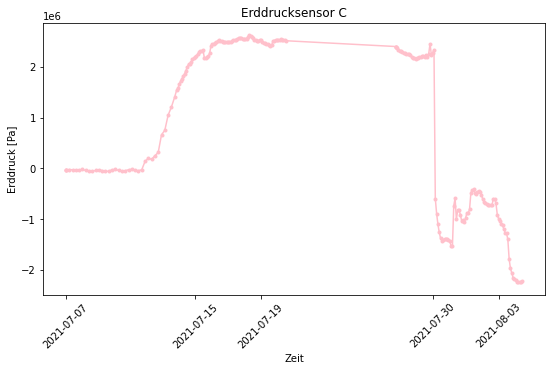

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor C')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSC[0:219], '.-', color='pink')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## EDS_D
The earth pressure cell EDS_D didn't work from the very start, no data was collected. 

## EDS_E

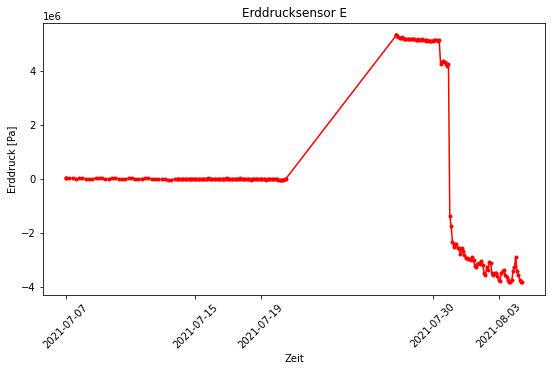

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor E')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSE[0:219], '.-', color='red')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## EDS_F

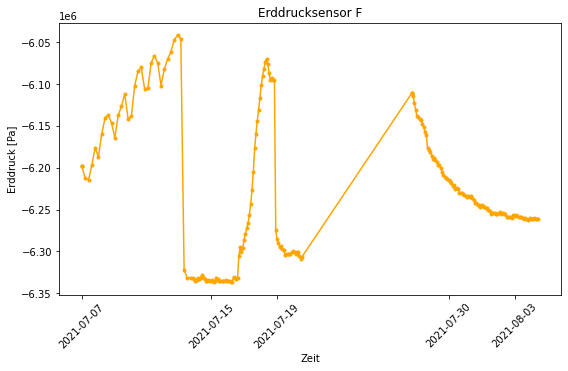

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor F')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSF[0:219], '.-', color='orange')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## EDS_G

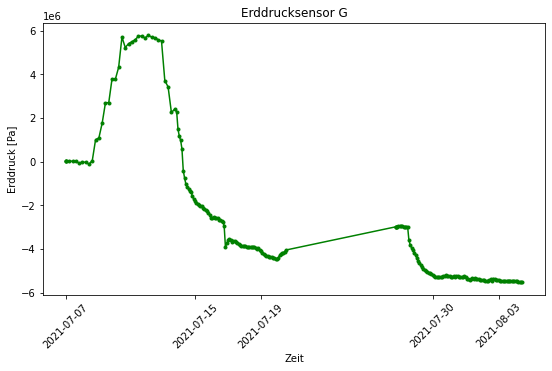

In [ ]:
# no NaN 

plt.figure(figsize=(9,5))
plt.title('Erddrucksensor G')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSG[0:219], '.-', color='green')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## Temperature effects

For the earth pressure cells A and B2, let's make an attempt at compensating for the temperature effects and see if the data is usable. 

### Correction of the air temperature effect

In [ ]:
# EDS_A

# save the data in a new column named EDSA_new (instead of EDSA)
for index, row in df_catman.iterrows():
  a = 3077.36121903
  T_avg = round(df_catman['Temperatur aussen'].mean(), 2)
  df_catman.at[index, 'EDSA_new'] = df_catman.at[index, 'EDSA'] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

In [ ]:
# EDS_B2

# save the data in a new column named EDSB2_new (instead of EDSB2)
for index, row in df_catman.iterrows():
  a = 1537.24514761
  T_avg = round(df_catman['Temperatur aussen'].mean(), 2)
  df_catman.at[index, 'EDSB2_new'] = df_catman.at[index, 'EDSB2'] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a

In [ ]:
# downsampling to a weekly frequency
eds_cols = ['Zeit', 'EDSA', 'EDSA_new', 'EDSB2', 'EDSB2_new']
df_eds = df_catman[eds_cols]

df_eds_downsample = df_eds.resample('W', on='Zeit').mean()

df_eds_downsample

# The dataframe below does not contain data from 15.08.2021 to 31.10.2021. 
# In fact, the file "rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv" 
# does not contain all raw data collected with Catman, but only measurements 
# 0 to 4 and 12 to 18 (5 to 11 not retrieved). 

,EDSA,EDSA_new,EDSB2,EDSB2_new
Zeit,,,,
2021-07-11,-3181.447233,-60758.875641,NaN,NaN
2021-07-18,-1795.344735,-40180.452429,NaN,NaN
2021-07-25,1052.203029,-44139.840972,NaN,NaN
2021-08-01,-778.706772,-39395.906462,NaN,NaN
2021-08-08,-9295.562535,-36332.051980,NaN,NaN
2021-08-15,NaN,NaN,NaN,NaN
2021-08-22,NaN,NaN,NaN,NaN
2021-08-29,NaN,NaN,NaN,NaN
2021-09-05,NaN,NaN,NaN,NaN


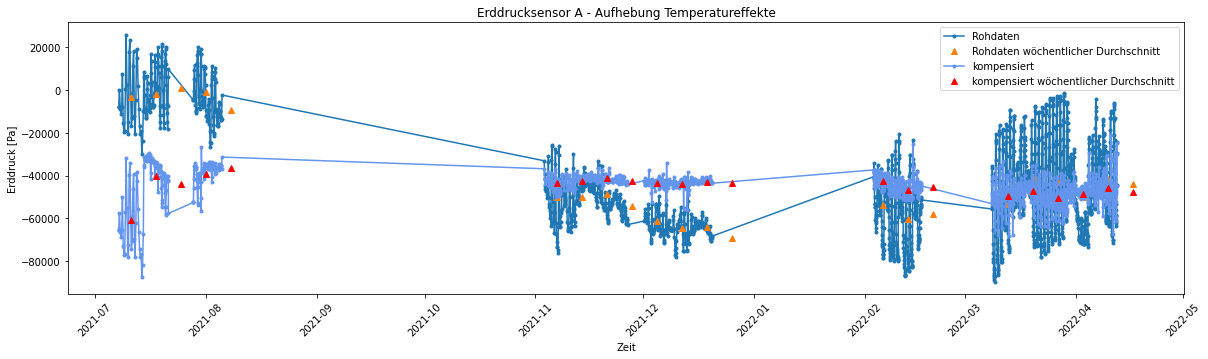

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor A - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSA, '.-', label='Rohdaten')
plt.plot(df_eds_downsample.EDSA, '^', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_catman.Zeit, df_catman.EDSA_new, '.-', color='cornflowerblue', label='kompensiert')
plt.plot(df_eds_downsample.EDSA_new, 'r^', label='kompensiert wöchentlicher Durchschnitt')

plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()

# As it is known from the pre-processing of the strain gauges data, it's 
# impossible to completely eliminate the temperature effects. Nonetheless, the 
# variation has greatly diminished. 

# For the downsampled and temperature compensated data we have a plausible 
# order of magnitude (roughly -40 kPa) with relative small variance. 
# However, the sign remains negative. 

<ipython-input-30-7f9db6462f16>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_eds_downsample.EDSB2_new, 'r^', color='orchid', label='kompensiert wöchentlicher Durchschnitt')


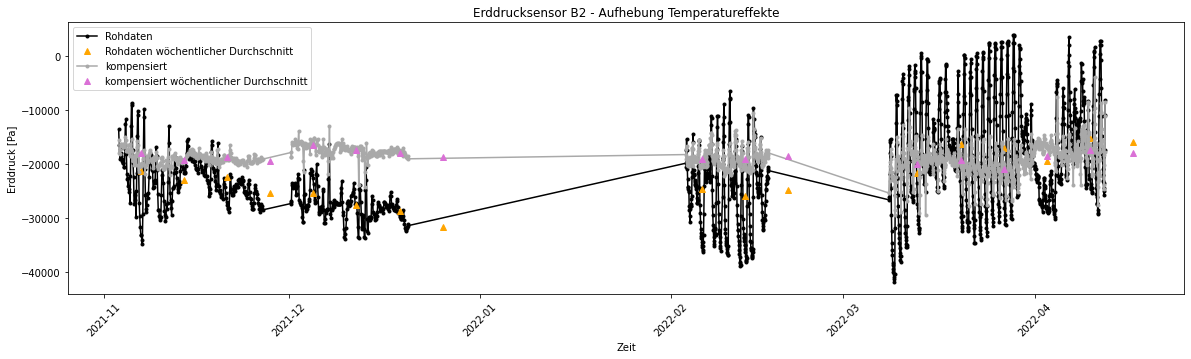

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor B2 - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSB2, '.-', color='black', label='Rohdaten')
plt.plot(df_eds_downsample.EDSB2, '^', color='orange', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_catman.Zeit, df_catman.EDSB2_new, '.-', color='darkgrey', label='kompensiert')
plt.plot(df_eds_downsample.EDSB2_new, 'r^', color='orchid', label='kompensiert wöchentlicher Durchschnitt')

plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()

# Same as above. 

In [ ]:
# Compare the values of two measuring periods: November (baseline) and April (end of construction works)

# month of November 
df_winter = df_eds_downsample[(df_eds_downsample.index >= datetime(2021, 11, 1))]
df_winter = df_winter[(df_winter.index <= datetime(2021, 11, 30))]
mean_winter = pd.Series(round(df_winter.mean()), name='mean November 2021')

# month of April
df_spring = df_eds_downsample[(df_eds_downsample.index >= datetime(2022, 4, 1))]
mean_spring = pd.Series(round(df_spring.mean()), name='mean April 2022')



delta = pd.Series(dtype='float')

for col in df_winter.columns:
  delta[col] = round(df_spring[col].mean() - df_winter[col].mean())

delta = pd.Series(delta, name='difference [Pa]: ')
df_evaluation = pd.DataFrame(data=[mean_winter, mean_spring, delta])
df_evaluation

# For EDS_A we expect the pressure to drop to zero, as the earth pressure cell is exposed by the excavation works. 
# For EDS_B2 we expect a pressure reduction, as the soil stresses change from rest (K0) to active (Ka).
# The expected trends (increase/decrease, sign, etc) cannot be observed. We must conclude that the pressure cells are probably faulty. 

,EDSA,EDSA_new,EDSB2,EDSB2_new
mean November 2021,-50762.0,-42524.0,-22972.0,-18857.0
mean April 2022,-45142.0,-47351.0,-16816.0,-17919.0
difference [Pa]:,5620.0,-4826.0,6156.0,938.0


### Investigating offset
The previous correction have been done by assuming that the EDS was always at the temperature of the air. Actually, it may be assumed, at least for B2, that the very first measure have been performed while the sensor still had a temperature of 20°.
In other words we consider that the very first measured value is "True"

> The following part take into account of this offset in the correction 

In [ ]:
# setting offset assuming first value taken for a temperatur of 20°C
df_eds_downsample2 = df_eds_downsample.copy()

df_eds_downsample2['EDSA_new_offset'] = df_eds_downsample2['EDSA_new'] + (df_catman['EDSA'].iloc[0] - df_catman['EDSA_new'].iloc[0])
df_eds_downsample2['EDSB2_new_offset'] = df_eds_downsample2['EDSB2_new'] + (df_catman['EDSB2'].dropna().iloc[0] - df_catman['EDSB2_new'].dropna().iloc[0])

#### EDS A

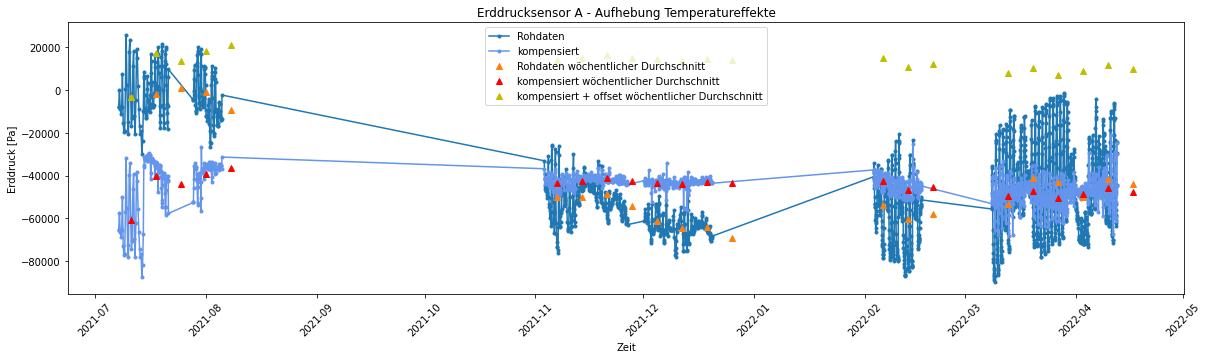

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor A - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSA, '.-', label='Rohdaten')
plt.plot(df_catman.Zeit, df_catman.EDSA_new, '.-', color='cornflowerblue', label='kompensiert')


plt.plot(df_eds_downsample2.EDSA, '^', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_eds_downsample2.EDSA_new, 'r^', label='kompensiert wöchentlicher Durchschnitt')
plt.plot(df_eds_downsample2.EDSA_new_offset, 'y^', label='kompensiert + offset wöchentlicher Durchschnitt')


plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()


In [ ]:
df_eds_downsample2.EDSA_new_offset.dropna()

Zeit
2021-07-11    -3181.447233
2021-07-18    17396.975979
2021-07-25    13437.587436
2021-08-01    18181.521946
2021-08-08    21245.376428
2021-11-07    13964.754108
2021-11-14    14839.046565
2021-11-21    16299.995380
2021-11-28    15108.299111
2021-12-05    14317.950777
2021-12-12    13785.399100
2021-12-19    14739.412208
2021-12-26    14289.209400
2022-02-06    14892.568268
2022-02-13    10986.477448
2022-02-20    12078.402415
2022-03-13     8025.843893
2022-03-20    10383.548341
2022-03-27     7044.224521
2022-04-03     9033.271491
2022-04-10    11676.663674
2022-04-17     9970.804760
Name: EDSA_new_offset, dtype: float64

Conclusion:
- positive values while development passiver Eddruck during very first stage of excavation  
- returns toward 0 during excavation  
- order of magnitude expected  

Sensor i.O


**umc2:**

As a baseline, we expect values between 7.5 and 10 kPa:

$\sigma_v = 1.0 m * \gamma = 15 - 20 kPa$

$e_0 = K_0 * \sigma_v = 0.5 * (15 - 20 kPa) = 7.5 - 10 kPa$

The baseline is pretty good :) 

After the excavation, the pressures should drop to zero because the sensor is exposed to the air. However, the values drop by roughly 30%, not more. Therefore, it seems like a stretch to say the sensor is i.O.

#### EDS B2

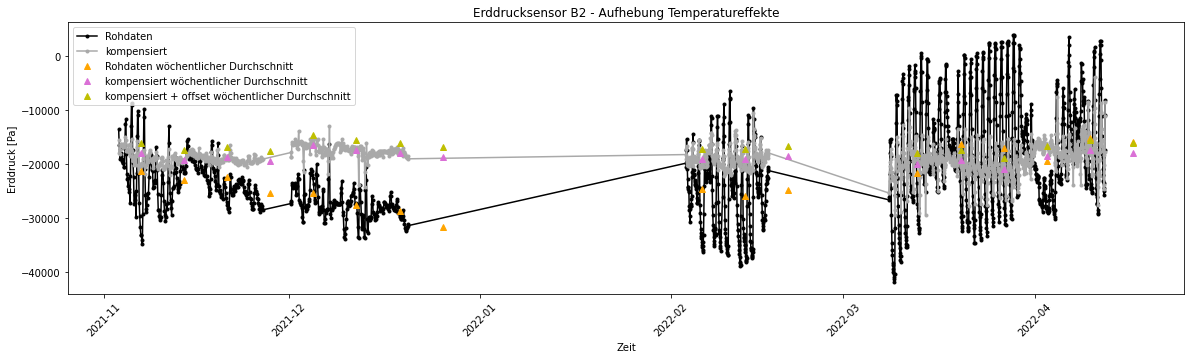

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor B2 - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSB2, '.-', color='black', label='Rohdaten')
plt.plot(df_catman.Zeit, df_catman.EDSB2_new, '.-', color='darkgrey', label='kompensiert')


plt.plot(df_eds_downsample2.EDSB2, '^', color='orange', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_eds_downsample2.EDSB2_new, '^', color='orchid', label='kompensiert wöchentlicher Durchschnitt')
plt.plot(df_eds_downsample2.EDSB2_new_offset, 'y^', label='kompensiert + offset wöchentlicher Durchschnitt')


plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
df_eds_downsample2.EDSB2_new_offset.dropna()

Zeit
2021-11-07   -16171.567808
2021-11-14   -17406.004328
2021-11-21   -16881.275413
2021-11-28   -17527.799681
2021-12-05   -14678.243635
2021-12-12   -15483.376781
2021-12-19   -16114.175960
2021-12-26   -16877.014700
2022-02-06   -17243.737340
2022-02-13   -17243.387575
2022-02-20   -16579.070964
2022-03-13   -18047.276295
2022-03-20   -17457.788839
2022-03-27   -18968.402705
2022-04-03   -16655.325959
2022-04-10   -15503.399444
2022-04-17   -16017.357262
Name: EDSB2_new_offset, dtype: float64

Conclusion:
- no significant differences with and without offset
- order of magnitue seems i.O (see comparison with Plaxis model)

Sensor i.O


**umc2**:

The sign is negative!!!! How can the sensor be i.O.?!

As the baseline, we expect values between 20 and 27 kPa:

$\sigma_v = 2.7 m * \gamma = 40.5 - 54 kPa$

$e_0 = K_0 * \sigma_v = 0.5 * (40.5 - 54 kPa) = 20 - 27 kPa$

The baseline is a bit low but not completely off. There is NO CHANGE WHATSOEVER AFTER THE EXCAVATION. How can the sensor be i.O.?!

## Summary measures EDS

The EDS do dot seem to deliver any insight into the earth pressures acting on the steel sheet piles:

*   EDS_B, EDS_C, EDS_D, EDS_E, EDS_F, and EDS_G: the data looks nonsensical. 

*   EDS_A and EDS_B2 show the same pattern as the strain gauges with respect to temperature effects.

## Comparison EDS with Plaxis simulations

### Import horizontal stresses Plaxis

In [ ]:
import pandas as pd
active = pd.read_csv('./test/Erddruck Aktiv.csv', sep=';')
active['Y'] = active['Y_coordinate_[m]_04']
active = active.loc[active['Y'] > -4]
active = active[['Y', 'Aktiv_04', 'Aktiv_06']]

In [ ]:
active

,Y,Aktiv_04,Aktiv_06
0,0.5,0.11,0.27
1,0.0,-0.20,-1.03
2,0.0,-0.20,-1.03
3,0.0,-0.27,-1.07
4,0.0,-2.28,-2.40
5,-0.5,-1.09,-1.50
6,-0.5,-1.10,-1.50
7,-0.5,-1.09,-1.51
8,-1.0,0.11,-2.40
9,-1.0,0.05,-2.40


In [ ]:
import plotly.express as px
fig = px.line(active, x=['Aktiv_04', 'Aktiv_06'], y="Y")
fig.show()

In [ ]:
# groupby to have one single value at a given depth
active = active.groupby('Y').mean()
active = active.reset_index()

In [ ]:
fig = px.line(active, x=['Aktiv_04', 'Aktiv_06'], y="Y")
fig.show()

### Import measured data
> **B2** only exploitable  
> **A** not exploitable as in the excavated zone => could be compared with Passiver Erdruck during Plaxis stages

#### Without offset

In [ ]:
from datetime import datetime

# estimated date aushub
date_aushub = datetime(year=2022, month=4, day=1)

# EDSA_new = df_eds_downsample[["EDSA_new"]] / 1000
# EDSA_new = EDSA_new.rename(columns={"EDSA_new": 'ED'})
# EDSA_new = EDSA_new.reset_index()
# EDSA_new['Y'] = -0.5
# EDSA_new_before_ex = EDSA_new.loc[EDSA_new['Zeit'] < date_aushub]
# EDSA_new_after_ex = EDSA_new.loc[EDSA_new['Zeit'] >= date_aushub]

EDSB2_new = df_eds_downsample[["EDSB2_new"]]  / 1000
EDSB2_new = EDSB2_new.rename(columns={"EDSB2_new": 'ED'})
EDSB2_new = EDSB2_new.reset_index()
EDSB2_new['Y'] = -2.7
EDSB2_new_before_ex = EDSB2_new.loc[EDSB2_new['Zeit'] < date_aushub]
EDSB2_new_after_ex = EDSB2_new.loc[EDSB2_new['Zeit'] >= date_aushub]

In [ ]:
EDSB2_new_before_ex

,Zeit,ED,Y
0,2021-07-11,NaN,-2.7
1,2021-07-18,NaN,-2.7
2,2021-07-25,NaN,-2.7
3,2021-08-01,NaN,-2.7
4,2021-08-08,NaN,-2.7
5,2021-08-15,NaN,-2.7
6,2021-08-22,NaN,-2.7
7,2021-08-29,NaN,-2.7
8,2021-09-05,NaN,-2.7
9,2021-09-12,NaN,-2.7


In [ ]:
EDSB2_new_after_ex

,Zeit,ED,Y
38,2022-04-03,-18.515393,-2.7
39,2022-04-10,-17.363466,-2.7
40,2022-04-17,-17.877424,-2.7


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=active['Aktiv_04'], y=active['Y'],
                    mode='lines',
                    name=r'$\text{Plaxis, after excavation,  }\beta = 0.4$'))
fig.add_trace(go.Scatter(x=active['Aktiv_06'], y=active['Y'],
                    mode='lines',
                    name=r'$\text{Plaxis, after excavation,  }\beta = 0.6$'))

fig.add_trace(go.Scatter(x=EDSB2_new_before_ex['ED'], y=EDSB2_new_before_ex['Y'],
                    mode='markers',
                    marker_color ="lightgreen",
                    name=r'$\text{Measures B2, before excavation}$'))

fig.add_trace(go.Scatter(x=[EDSB2_new_before_ex['ED'].mean()],
                         y=[EDSB2_new_before_ex['Y'].dropna().iloc[0]],
                    mode='markers',
                    marker_symbol="cross",
                    marker_color="lightgreen",
                    marker_size=15,
                    name=r'$\text{Mean B2, before excavation}$'))

fig.add_trace(go.Scatter(x=EDSB2_new_after_ex['ED'], y=EDSB2_new_after_ex['Y'],
                    mode='markers',
                    marker_color="orange",
                    name=r'$\text{Measures B2, after excavation}$'))


fig.add_trace(go.Scatter(x=[EDSB2_new_after_ex['ED'].mean()],
                         y=[EDSB2_new_after_ex['Y'].dropna().iloc[0]],
                    mode='markers',
                    marker_symbol="cross",
                    marker_color="orange",
                    marker_size=15,
                    name=r'$\text{Mean B2, after excavation}$'))

fig.update_layout(
    xaxis_title="Active Earth Pressure [kPa]",
    yaxis_title="Depth [m]",
    legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01
      ),
)


fig.show()

#### With offset

In [ ]:
from datetime import datetime

# estimated date aushub
date_aushub = datetime(year=2022, month=4, day=1)


EDSB2_new2 = df_eds_downsample2[["EDSB2_new_offset"]]  / 1000
EDSB2_new2 = EDSB2_new2.rename(columns={"EDSB2_new_offset": 'ED_offset'})
EDSB2_new2 = EDSB2_new2.reset_index()
EDSB2_new2['Y'] = -2.7
EDSB2_new2_before_ex = EDSB2_new2.loc[EDSB2_new2['Zeit'] < date_aushub]
EDSB2_new2_after_ex = EDSB2_new2.loc[EDSB2_new2['Zeit'] >= date_aushub]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=active['Aktiv_04'], y=active['Y'],
                    mode='lines',
                    name=r'$\text{Plaxis, after excavation,  }\beta = 0.4$'))
fig.add_trace(go.Scatter(x=active['Aktiv_06'], y=active['Y'],
                    mode='lines',
                    name=r'$\text{Plaxis, after excavation,  }\beta = 0.6$'))

fig.add_trace(go.Scatter(x=EDSB2_new2_before_ex['ED_offset'], y=EDSB2_new_before_ex['Y'],
                    mode='markers',
                    marker_color ="lightgreen",
                    name=r'$\text{Measures B2, before excavation}$'))

fig.add_trace(go.Scatter(x=[EDSB2_new2_before_ex['ED_offset'].mean()],
                         y=[EDSB2_new2_before_ex['Y'].dropna().iloc[0]],
                    mode='markers',
                    marker_symbol="cross",
                    marker_color="lightgreen",
                    marker_size=15,
                    name=r'$\text{Mean B2, before excavation}$'))

fig.add_trace(go.Scatter(x=EDSB2_new2_after_ex['ED_offset'], y=EDSB2_new2_after_ex['Y'],
                    mode='markers',
                    marker_color="orange",
                    name=r'$\text{Measures B2, after excavation}$'))


fig.add_trace(go.Scatter(x=[EDSB2_new2_after_ex['ED_offset'].mean()],
                         y=[EDSB2_new2_after_ex['Y'].dropna().iloc[0]],
                    mode='markers',
                    marker_symbol="cross",
                    marker_color="orange",
                    marker_size=15,
                    name=r'$\text{Mean B2, after excavation}$'))

fig.update_layout(
    title = "B2 corrected (temperature and offset)",
    xaxis_title="Active Earth Pressure [kPa]",
    yaxis_title="Depth [m]",
    legend=dict(
      yanchor="top",
      y=0.99,
      xanchor="left",
      x=0.01
      ),
)


fig.show()